In [1]:
import pandas as pd
import numpy as np

#df = pd.read_csv('reduced_model_ETC_core_20250228-213124_continuous_steady_state_fuel_competition_10_fold.csv')
df = pd.read_csv('reduced_model_ETC_core_20250228-213124_continuous_steady_state_fuel_competition_10_fold_no_reg.csv')
df.shape



(9240, 138)

In [2]:
# Load only the robust parameters samples
from skimpy.core.parameters import load_parameter_population
#parameter_population = load_parameter_population('./../reduced_model_ETC_core_20250228-213124_tfa_sampling_pruned_parameters.hdf5')
parameter_population = load_parameter_population('./../reduced_model_ETC_core_20250228-213124_tfa_sampling_pruned_parameters_no_reg.hdf5')

In [3]:
# Prin the head for the net fluxes of LDH_L, LDH_Lm, PYRt2m, 
df[['LDH_L', 'LDH_Lm', 'PYRt2m','L_LACt2r','L_LACtm','parameter','pertubration']].head()

,LDH_L,LDH_Lm,PYRt2m,L_LACt2r,L_LACtm,parameter,pertubration
0,-0.162371,0.035580,0.046427,-0.126791,0.035580,lac_L_e,0.100000
1,-0.162669,0.038792,0.046129,-0.123877,0.038792,lac_L_e,0.125893
2,-0.163026,0.042685,0.045772,-0.120341,0.042685,lac_L_e,0.158489
3,-0.163444,0.047360,0.045354,-0.116084,0.047360,lac_L_e,0.199526
4,-0.163924,0.052911,0.044875,-0.111013,0.052911,lac_L_e,0.251189


In [4]:
# Compute glucose and lactate oxidation rates 
# vnet = vfwd - vback and vback/vfwd = gamma 
# vbwd = vent * gamma / (1 - gamma)
# vfwd = vent / (1 - gamma)
df['LDH_L_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_LDH_L'], axis=1)
df['LDH_L_gamma'] = 1 / (1 / df['LDH_L_Keq'] * df['pyr_c'] * df['nadh_c'] * df['h_c'] / (df['lac_L_c'] * df['nad_c']))  # Thermodynamics displacement
# if neg invert forward and reverse
df['LDH_L_rvs'] =  -1 * df['LDH_L'] * df['LDH_L_gamma'] / (1 - df['LDH_L_gamma'])
df['LDH_L_fwd'] =  -1 * df['LDH_L'] / (1 - df['LDH_L_gamma'])

# Same for LDH_Lm
df['LDH_Lm_Keq'] =  df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_LDH_Lm'], axis=1)
df['LDH_Lm_gamma'] = 1 / df['LDH_Lm_Keq'] * df['pyr_m'] * df['nadh_m'] * df['h_m'] / (df['lac_L_m'] * df['nad_m'])  # Thermodynamics displacement
df['LDH_Lm_fwd'] =  df['LDH_Lm'] / (1 - df['LDH_Lm_gamma'])
df['LDH_Lm_rvs'] =  df['LDH_Lm'] * df['LDH_Lm_gamma'] / (1 - df['LDH_Lm_gamma']) 

# Same for pyruvate transport
df['PYRt2m_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_PYRt2m'], axis=1)
df['PYRt2m_gamma'] =  1 / df['PYRt2m_Keq'] * df['pyr_m'] * df['h_m'] / (df['pyr_c'] * df['h_c'])  # Thermodynamics displacement
df['PYRt2m_fwd'] = df['PYRt2m']/ (1 - df['PYRt2m_gamma'])
df['PYRt2m_rvs'] =  df['PYRt2m']  * df['PYRt2m_gamma']  / (1 - df['PYRt2m_gamma'])

# Lactate transport to cyto
df['L_LACt2r_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_L_LACt2r'], axis=1)
df['h_e'] = df.apply(lambda x: parameter_population[x['parameter_set']]['h_e'], axis=1)
df['lac_L_e']= df.apply(lambda x: parameter_population[x['parameter_set']]['lac_L_e'], axis=1)
df['lac_L_e_mod'] = df.apply(lambda x: x['lac_L_e'] * (x['pertubration']) if 'lac_L_e' == x['parameter'] else x['lac_L_e'], axis=1)  # change lac_L_e based on the perturbation if lac_L_e is in parameter columns of df
# change lac_L_e based on the perturbation if lac_L_e is in parameter columns of df 
df['L_LACt2r_gamma'] = 1.0/ (1.0 / df['L_LACt2r_Keq'] * df['lac_L_c'] * df['h_c'] / (df['lac_L_e_mod'] * df['h_e']))  # Thermodynamics displacement
df['L_LACt2r_rvs'] = -1 * df['L_LACt2r'] * df['L_LACt2r_gamma'] / (1 - df['L_LACt2r_gamma'])
df['L_LACt2r_fwd'] = -1 * df['L_LACt2r'] / (1 - df['L_LACt2r_gamma'])


# Lacgate transport to mito 
df['L_LACtm_Keq'] = df.apply(lambda x: parameter_population[x['parameter_set']]['k_equilibrium_L_LACtm'], axis=1)
df['L_LACtm_gamma'] = 1.0 / df['L_LACtm_Keq'] * df['lac_L_m'] * df['h_m'] / (df['lac_L_c'] * df['h_c'])  # Thermodynamics displacement
df['L_LACtm_fwd'] = df['L_LACtm'] / (1 - df['L_LACtm_gamma'])
df['L_LACtm_rvs'] = df['L_LACtm'] * df['L_LACtm_gamma'] / (1 - df['L_LACtm_gamma'])


In [5]:
# Rename some things for simplicity
df['gly'] = df['PYK']

df['ltf'] = df['L_LACt2r_fwd'] 
df['ltr'] = df['L_LACt2r_rvs']

df['ldhf'] = df['LDH_L_fwd']
df['ldhr'] = df['LDH_L_rvs']

df['lmtf'] = df['L_LACtm_fwd']
df['lmtr'] = df['L_LACtm_rvs']

df['ptf'] = df['PYRt2m_fwd']
df['ptr'] = df['PYRt2m_rvs']

df['ldhmf'] = df['LDH_Lm_fwd']
df['ldhmr'] = df['LDH_Lm_rvs']

df['pdh'] = df['PDHm']

In [6]:
# Mass balance of mitochondiral pyruvate
PM = {'pdh':-1, 'ldhmf':1, 'ldhmr':-1,  'ptr':-1, 'ptf':1}

# Sum these colums weighted by the PM
df[list(PM.keys())].mul(pd.Series(PM), axis=1).sum(axis=1)


0      -2.008699e-12
1      -6.538797e-12
2      -1.637321e-11
3       7.292014e-13
4       5.214610e-11
            ...     
9235   -1.360111e-11
9236    5.837625e-10
9237    5.293981e-11
9238   -3.404463e-10
9239    6.813661e-11
Length: 9240, dtype: float64

In [7]:
# Mass balance of cytosolic pyruvate
PC = {'gly':1, 'ldhf':-1, 'ldhr':1, 'ptr':1, 'ptf':-1}
# Sum these colums weighted by the PC
df[list(PC.keys())].mul(pd.Series(PC), axis=1).sum(axis=1)

0      -1.072805e-10
1       8.590109e-10
2       2.720782e-09
3       1.449998e-11
4      -1.371544e-08
            ...     
9235   -4.741020e-12
9236   -1.042573e-09
9237    1.264389e-11
9238    9.218870e-10
9239    1.260929e-11
Length: 9240, dtype: float64

In [8]:
# Mass balance of mitochondrial lactate
ML = {'ldhmf':-1, 'ldhmr':1, 'lmtf':1, 'lmtr':-1, }
# Sum these colums weighted by the ML
df[list(ML.keys())].mul(pd.Series(ML), axis=1).sum(axis=1)

0       3.429308e-09
1       1.505847e-09
2      -6.736267e-09
3      -1.062971e-09
4      -1.082298e-08
            ...     
9235   -1.386761e-08
9236    1.560548e-08
9237    2.975908e-08
9238   -1.823495e-09
9239    2.817030e-08
Length: 9240, dtype: float64

In [9]:
# Mass balance of cytosolic lactate
PL = {'ldhf':1, 'ldhr':-1, 'ltf':-1, 'ltr':1, 'lmtf':-1, 'lmtr':1}
# Sum these colums weighted by the PL
df[list(PL.keys())].mul(pd.Series(PL), axis=1).sum(axis=1)

0       3.990470e-10
1      -7.744738e-10
2      -3.533238e-09
3      -1.245839e-10
4       1.522684e-08
            ...     
9235   -5.391794e-10
9236   -2.653619e-08
9237    3.809921e-10
9238    1.863215e-08
9239   -5.400747e-11
Length: 9240, dtype: float64

In [10]:


# # Expression for glucose oxidation graction (contribition of glucose to mit pyruvate)
# (gly (ldhf ldhmf ltmf + ldhmf (ldhr + ltf + ltmf) ptf + (ldhr + ltf) ltmr ptf))/
# ((ldhmr ltf ltmr + ldhmf (ldhr + ltf + ltmf) pdh + (ldhr + ltf) ltmr pdh) ptf 
#   + ldhf (ldhmr ltf ltmr + ldhmf (ltf + ltmf) pdh + ltf ltmr pdh + ltf (ldhmf + ltmr) ptr))

df['glucose_pyruvate'] = (
    (df['gly'] * (df['ldhf'] * df['ldhmf'] * df['lmtf'] 
     + df['ldhmf'] * (df['ldhr'] + df['ltf'] + df['lmtf']) * df['ptf'] 
     + (df['ldhr'] + df['ltf']) * df['lmtr'] * df['ptf'])) 
     / 
     ((df['ldhmr'] * df['ltf'] * df['lmtr'] +  df['ldhmf'] * (df['ldhr'] + df['ltf'] + df['lmtf']) * df['pdh'] 
       + (df['ldhr'] + df['ltf']) * df['lmtr'] * df['pdh']) * df['ptf'] +
    df['ldhf'] * (df['ldhmr'] * df['ltf'] * df['lmtr'] + df['ldhmf'] * (df['ltf'] + df['lmtf']) * df['pdh'] 
                  + df['ltf'] * df['lmtr'] * df['pdh'] + df['ltf'] * (df['ldhmf'] + df['lmtr']) * df['ptr']))) 


# # Expression for lactate oxidation graction (contribition of lactate to mit pyruvate)
# (ltr (ldhf ldhmf ltmf + ldhmf (ldhr + ltmf) ptf +
#      ldhr ltmr ptf))/((ldhmr ltf ltmr +
#       ldhmf (ldhr + ltf + ltmf) pdh + (ldhr + ltf) ltmr pdh) ptf +
#    ldhf (ldhmr ltf ltmr + ldhmf (ltf + ltmf) pdh + ltf ltmr pdh +
#       ltf (ldhmf + ltmr) ptr))


df['lactate_pyruvate'] =  ((df['ltr'] * (df['ldhf'] * df['ldhmf'] * df['lmtf'] +
                                df['ldhmf'] * (df['ldhr'] + df['lmtf']) * df['ptf'] +
                                df['ldhr'] * df['lmtr'] * df['ptf'])) / (
    (df['ldhmr'] * df['ltf'] * df['lmtr'] +
     df['ldhmf'] * (df['ldhr'] + df['ltf'] + df['lmtf']) * df['pdh'] +
     (df['ldhr'] + df['ltf']) * df['lmtr'] * df['pdh']) * df['ptf'] +
    df['ldhf'] * (df['ldhmr'] * df['ltf'] * df['lmtr'] +
                  df['ldhmf'] * (df['ltf'] + df['lmtf']) * df['pdh'] +
                  df['ltf'] * df['lmtr'] * df['pdh'] +
                  df['ltf'] * (df['ldhmf'] + df['lmtr']) * df['ptr']))) 


In [11]:
df['lactate_ox'] = df['lactate_pyruvate'] * df['pdh']  # Lactate oxidation rate is lactate pyruvate flux times PDHm
df['glucose_ox'] = df['glucose_pyruvate'] * df['pdh'] / 2  # Glucose oxidation rate is glucose pyruvate flux times PDHm

In [12]:
uptake_fluxes = ['glucose_ox', 'lactate_ox', 'HDCAtr', 'BHBt']
n_carbons = [6, 3, 16, 4]  # Number of carbons in each uptake flux

In [13]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1.0 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING


In [14]:
results = df.copy()

In [15]:
# Flux constraints for the core model 
RER = 0.79
fraction_of_whole_body_o2 = 0.7

o2_uptake = 2.0 * fraction_of_whole_body_o2 
co2_production = o2_uptake * RER 

# Total amount of CO2 produced for a 25g STD mouse 
co2_production/0.8/0.8 * 25 # umol/min

43.20312499999999

In [16]:
# Scale data 
for i, (uptake_flux, nc) in enumerate(zip(uptake_fluxes, n_carbons)):
    df.loc[:,uptake_flux] = df.loc[:,uptake_flux] * nc

In [17]:
# Compute the change for a ten fold perturbation 

results = {}

# Estimate the slope # at fold changes based on x0.5 and x2.0 perturbations
p1 = df['pertubration'].unique()[7]
p0 = df['pertubration'].unique()[10]
p2 = df['pertubration'].unique()[13]

# p1 = df['pertubration'].unique()[15]
# p0 = df['pertubration'].unique()[25]
# p2 = df['pertubration'].unique()[35]

for perturbation in ['glc_D_e', 'lac_L_e', 'hdca_e', 'bhb_e']:

    # Uptake fluxes at low perturbation
    uptake_flux_low = df.loc[(df['pertubration'] == p1)  & (df['parameter'] == perturbation)][uptake_fluxes].reset_index(drop=True)
    # Uptake fluxes at high perturbation
    uptake_flux_high = df.loc[(df['pertubration'] == p2)  & (df['parameter'] == perturbation)][uptake_fluxes].reset_index(drop=True)
    # Uptake fluxes at reference
    uptake_flux_medium = df.loc[(df['pertubration'] == p0)  & (df['parameter'] == perturbation)][uptake_fluxes].reset_index(drop=True)


    # Compute the log slope
    slope = (uptake_flux_high - uptake_flux_low) / (p2 - p1) * p0 / uptake_flux_medium
    
    # Relative change in uptake fluxes
    # slope = (uptake_flux_high - uptake_flux_medium)

    results[perturbation] = slope


# Horizontally concatenate the results into a DataFrame 
# rename the columns to include the perturbation name
for k, v in results.items():
    v.columns = [f"{k}_{col}" for col in v.columns]

results_df = pd.concat(results.values(), axis=1)

# FIlter out any positive off diagonals: 
off_diagonal = [ 'glc_D_e_lactate_ox', 'glc_D_e_HDCAtr', 'glc_D_e_BHBt',
    'lac_L_e_glucose_ox', 'lac_L_e_HDCAtr', 'lac_L_e_BHBt',
    'hdca_e_glucose_ox', 'hdca_e_lactate_ox', 'hdca_e_BHBt',
    'bhb_e_glucose_ox', 'bhb_e_lactate_ox', 'bhb_e_HDCAtr',]


In [18]:
parameter_set_index = df.loc[(df['pertubration'] == p1)  & (df['parameter'] == perturbation)]['parameter_set'].reset_index(drop=True)
    

In [19]:
sensitivities_simple = np.array( 
       [0.89622097, 0.80097167, 0.39160331,  0.91040174,  
        -0.10358208,-0.10358208,-0.10358208, 
        -0.19869065, -0.19869065, -0.19869065, 
        -0.6078915 ,  -0.6078915 , -0.6078915,
        -0.08942555, -0.08942555, -0.08942555,
       ])

order = [
    'glc_D_e_glucose_ox', 'lac_L_e_lactate_ox', 'hdca_e_HDCAtr', 'bhb_e_BHBt',
    'glc_D_e_lactate_ox', 'glc_D_e_HDCAtr', 'glc_D_e_BHBt',
    'lac_L_e_glucose_ox', 'lac_L_e_HDCAtr', 'lac_L_e_BHBt',
    'hdca_e_glucose_ox', 'hdca_e_lactate_ox', 'hdca_e_BHBt',
    'bhb_e_glucose_ox', 'bhb_e_lactate_ox', 'bhb_e_HDCAtr',
    ]


distance = ((results_df[order] - sensitivities_simple)).apply(lambda x: x**2, axis=1).sum(axis=1).apply(lambda x: np.sqrt(x))
# # Cosine distance
# from sklearn.metrics.pairwise import cosine_distances
# distance = cosine_distances(results_df[order], [sensitivities_simple])
# distance = pd.Series(distance.flatten(), index=results_df.index)

# Rank the index by distance
sorted_index = distance.sort_values(ascending=True).index

In [20]:
# SAve results to a CSV file
# Add distance and parameter_set_index to the results_df
results_df['distance'] = distance
results_df['parameter_set'] = parameter_set_index
results_df[order].loc[sorted_index].to_csv('distance_fuel_competition_results_no_reg.csv', index=False)

In [21]:
# Load the from the competitive catboalism formula
competitive_catabolism_data = pd.read_csv('../../minimal_model/output/competitive_catabolism_rates.csv')

# Map rate names 
mapping_dict = {
    'Glucose oxidation': 'glucose_ox',
    'Lactate oxidation': 'lactate_ox',
    'Fatty acids oxidation': 'HDCAtr',
    'Ketones oxidation': 'BHBt',
    }

competitive_catabolism_data['uptake_flux'] = competitive_catabolism_data['Rate'].map(mapping_dict)

# Mapp metabolites 
mapping_metabolites = {
    'Glucose': 'glc_D_e',
    'Lactate': 'lac_L_e',
    'Fatty acids': 'hdca_e',
    'Ketones': 'bhb_e',
}

competitive_catabolism_data['serum_conc'] = competitive_catabolism_data['Metabolite'].map(mapping_metabolites)

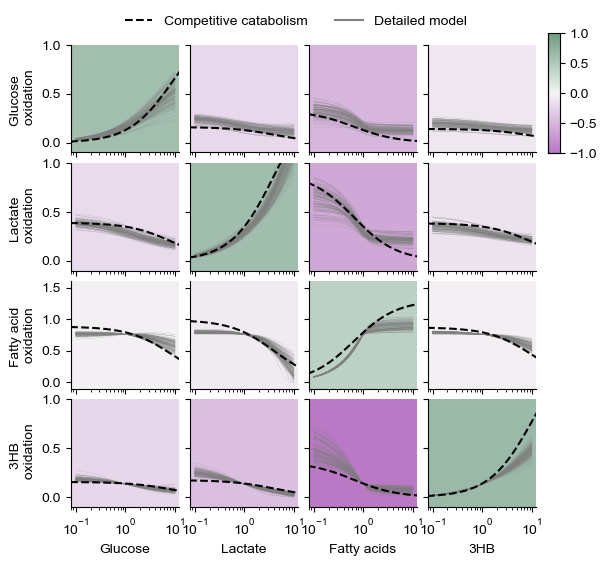

In [22]:
# Import the plotting library
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})


# Plot in a 4x4 grid 
# Parameter changes 
serum_concentrations = ['glc_D_e', 'lac_L_e', 'hdca_e', 'bhb_e', ]
 
# Y-Lables
ylabel = { 
            'glucose_ox': 'Glucose \n oxidation',
            'lactate_ox': 'Lactate \n oxidation', 
            'HDCAtr': 'Fatty acid \n oxidation ', 
            'BHBt': '3HB \n oxidation'} 

# X-Lables
xlabel = {'glc_D_e': 'Glucose', 
          'lac_L_e': 'Lactate', 
          'hdca_e': 'Fatty acids', 
          'bhb_e': '3HB'}

# Y limits for the respective uptake fluxes
ylim = {
    'glucose_ox': (-0.1, 1.0),
    'lactate_ox': (-0.1, 1.),
    'HDCAtr': (-0.1, 1.6),
    'BHBt': (-0.1, 1.0)
}

cmap = sns.diverging_palette(300,145, s=60, as_cmap=True)


# Make a grid of line plots share y-axis per row 
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey='row')
# Color the background of the plots as a heat map of the slope arround 0 perturbation
plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i, (uptake_flux, nc) in enumerate(zip(uptake_fluxes, n_carbons)):
    for j, serum_concentration in enumerate(serum_concentrations):
        this_data = df[df['parameter'] == serum_concentration].copy() 
        ax = axs[i, j]
        
        # Plot the competitive catabolism data
        # Select the data metabolite, and rate 
        this_competitive_data = competitive_catabolism_data[
            (competitive_catabolism_data['serum_conc'] == serum_concentration) & 
            (competitive_catabolism_data['uptake_flux'] == uptake_flux)
        ]
        
        sns.lineplot(data=this_data, x='pertubration', y=uptake_flux, 
                ax=ax, color='grey', 
                units="parameter_set",
                estimator=None,
                linewidth=0.2,
                alpha=0.5,
            )


        # Dashed line for the competitive catabolism data
        sns.lineplot(data=this_competitive_data, 
                     x='Concentration relative to reference', 
                     y='Rate (mmol/min/gBW)', 
                     ax=ax, 
                     errorbar=('pi',50), 
                     estimator='median', 
                     linestyle='--',
                     legend=False,
                     color='black',
                     )
        
        ax.set_xscale('log')
        
        # Horizontal line for 0 
        # ax.axhline(0, color='gray', linestyle='--')
        axs[i, j].set_ylim(ylim[uptake_flux])

        # Estimate the slope 
        p1 = df['pertubration'].unique()[7]
        p0 = df['pertubration'].unique()[10]
        p2 = df['pertubration'].unique()[13]

        # p1 = df['pertubration'].unique()[15]
        # p0 = df['pertubration'].unique()[25]
        # p2 = df['pertubration'].unique()[35]


        dy = (this_data[this_data['pertubration'] == p2][uptake_flux].reset_index(drop=True) - this_data[this_data['pertubration'] == p1][uptake_flux].reset_index(drop=True)).median()
        y = this_data[this_data['pertubration'] == p0][uptake_flux].reset_index(drop=True).median()

        dp = p2-p1
        slope = dy/dp/y
        scaled_epsilon = (slope + 1.0) / 2.0
        facecolor = cmap(scaled_epsilon)

        axs[i, j].set_facecolor(facecolor)      
        axs[i, j].patch.set_alpha(0.8)  

        # Only show the x-axis label and tick labels on the bottom row
        if i == 3:
            ax.set_xlabel(xlabel[serum_concentration])
        else:
            ax.set_xlabel('')
        
        # Only show the y-axis label and tick labels on the left column
        if j == 0:
            ax.set_ylabel(ylabel[uptake_flux])
        else:
            ax.set_ylabel('')


# Align the y-axis labels to left
fig.align_ylabels(axs[:, 0])

# Set y-ticks of the fatty acid oxidation to be 0.5, 1.0, 1.5
axs[2, 1].set_yticks([0.0, 0.5, 1.0, 1.5])
# Set x lims 
axs[3, 0].set_xlim(0.1*0.8, 10.0*1.2)

# Add a small colorbar in the right corner
cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.2])
norm = plt.Normalize(vmin=-1.0, vmax=1.0)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, alpha=0.8)

# Add a legend with two lines, one for the competitive catabolism data and one for the model data   
handles = [
    plt.Line2D([0], [0], color='black', linestyle='--', label='Competitive catabolism'),
    plt.Line2D([0], [0], color='grey', linestyle='-', label='Detailed model')
]

fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95), fontsize=10, frameon=False)

sns.despine()

#plt.savefig('literature_regulation_sensitivity_to_fuel_perturbations.svg', bbox_inches='tight')
plt.savefig('literature_regulation_sensitivity_to_fuel_perturbations_no_reg_all.svg', bbox_inches='tight')


In [23]:
# Downsample the number of parameter sets to plot
parameter_set_index = parameter_set_index[::10]

# Only keep in parameter set index the ones that are in the competitive catabolism data
df = df[df['parameter_set'].isin(parameter_set_index)]

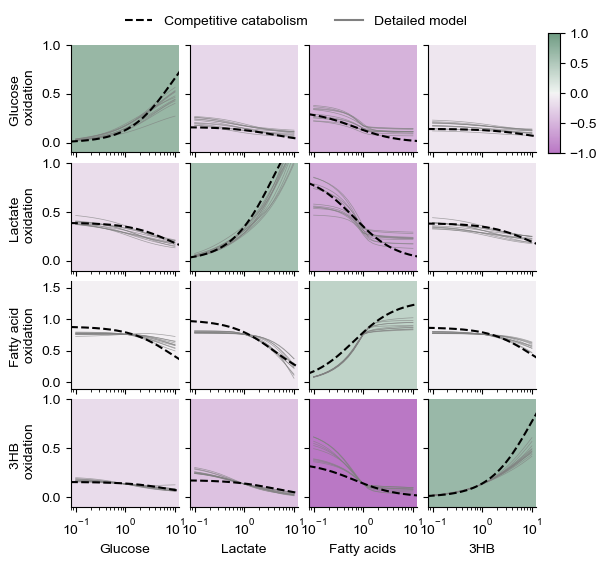

In [24]:
# Import the plotting library
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})


# Plot in a 4x4 grid 
# Parameter changes 
serum_concentrations = ['glc_D_e', 'lac_L_e', 'hdca_e', 'bhb_e', ]
 
# Y-Lables
ylabel = { 
            'glucose_ox': 'Glucose \n oxidation',
            'lactate_ox': 'Lactate \n oxidation', 
            'HDCAtr': 'Fatty acid \n oxidation ', 
            'BHBt': '3HB \n oxidation'} 

# X-Lables
xlabel = {'glc_D_e': 'Glucose', 
          'lac_L_e': 'Lactate', 
          'hdca_e': 'Fatty acids', 
          'bhb_e': '3HB'}

# Y limits for the respective uptake fluxes
ylim = {
    'glucose_ox': (-0.1, 1.0),
    'lactate_ox': (-0.1, 1.),
    'HDCAtr': (-0.1, 1.6),
    'BHBt': (-0.1, 1.0)
}

cmap = sns.diverging_palette(300,145, s=60, as_cmap=True)


# Make a grid of line plots share y-axis per row 
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey='row')
# Color the background of the plots as a heat map of the slope arround 0 perturbation
plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i, (uptake_flux, nc) in enumerate(zip(uptake_fluxes, n_carbons)):
    for j, serum_concentration in enumerate(serum_concentrations):
        this_data = df[df['parameter'] == serum_concentration].copy() 
        ax = axs[i, j]
        
        # Plot the competitive catabolism data
        # Select the data metabolite, and rate 
        this_competitive_data = competitive_catabolism_data[
            (competitive_catabolism_data['serum_conc'] == serum_concentration) & 
            (competitive_catabolism_data['uptake_flux'] == uptake_flux)
        ]
        
        sns.lineplot(data=this_data, x='pertubration', y=uptake_flux, 
                ax=ax, color='grey', 
                units="parameter_set",
                estimator=None,
                linewidth=0.5,
                alpha=0.7,
            )


        # Dashed line for the competitive catabolism data
        sns.lineplot(data=this_competitive_data, 
                     x='Concentration relative to reference', 
                     y='Rate (mmol/min/gBW)', 
                     ax=ax, 
                     errorbar=('pi',50), 
                     estimator='median', 
                     linestyle='--',
                     legend=False,
                     color='black',
                     )
        
        ax.set_xscale('log')
        
        # Horizontal line for 0 
        # ax.axhline(0, color='gray', linestyle='--')
        axs[i, j].set_ylim(ylim[uptake_flux])

        # Estimate the slope 
        p1 = df['pertubration'].unique()[7]
        p0 = df['pertubration'].unique()[10]
        p2 = df['pertubration'].unique()[13]

        # p1 = df['pertubration'].unique()[15]
        # p0 = df['pertubration'].unique()[25]
        # p2 = df['pertubration'].unique()[35]


        dy = (this_data[this_data['pertubration'] == p2][uptake_flux].reset_index(drop=True) - this_data[this_data['pertubration'] == p1][uptake_flux].reset_index(drop=True)).median()
        y = this_data[this_data['pertubration'] == p0][uptake_flux].reset_index(drop=True).median()

        dp = p2-p1
        slope = dy/dp/y
        scaled_epsilon = (slope + 1.0) / 2.0
        facecolor = cmap(scaled_epsilon)

        axs[i, j].set_facecolor(facecolor)      
        axs[i, j].patch.set_alpha(0.8)  

        # Only show the x-axis label and tick labels on the bottom row
        if i == 3:
            ax.set_xlabel(xlabel[serum_concentration])
        else:
            ax.set_xlabel('')
        
        # Only show the y-axis label and tick labels on the left column
        if j == 0:
            ax.set_ylabel(ylabel[uptake_flux])
        else:
            ax.set_ylabel('')


# Align the y-axis labels to left
fig.align_ylabels(axs[:, 0])

# Set y-ticks of the fatty acid oxidation to be 0.5, 1.0, 1.5
axs[2, 1].set_yticks([0.0, 0.5, 1.0, 1.5])
# Set x lims 
axs[3, 0].set_xlim(0.1*0.8, 10.0*1.2)

# Add a small colorbar in the right corner
cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.2])
norm = plt.Normalize(vmin=-1.0, vmax=1.0)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, alpha=0.8)

# Add a legend with two lines, one for the competitive catabolism data and one for the model data   
handles = [
    plt.Line2D([0], [0], color='black', linestyle='--', label='Competitive catabolism'),
    plt.Line2D([0], [0], color='grey', linestyle='-', label='Detailed model')
]

fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95), fontsize=10, frameon=False)

sns.despine()

#plt.savefig('literature_regulation_sensitivity_to_fuel_perturbations.svg', bbox_inches='tight')
plt.savefig('literature_regulation_sensitivity_to_fuel_perturbations_no_reg.svg', bbox_inches='tight')


In [25]:
# Dictionary mapping variable names to descriptive biochemical annotations
variable_annotation_dict = {
    'coa_m': 'Coenzyme A (mito)',
    'aacoa_m': 'Acetoacetyl-CoA (mito)',
    'accoa_m': 'Acetyl-CoA (mito)',
    'icit_m': 'Isocitrate (mito)',
    'cit_m': 'Citrate (mito)',
    'adp_c': 'ADP (cyt)',
    'atp_c': 'ATP (cyt)',
    'amp_c': 'AMP (cyt)',
    'h_c': 'Proton (cyt)',
    'succoa_m': 'Succinyl-CoA (mito)',
    'nadh_m': 'NADH (mito)',
    'co2_m': 'CO2 (mito)',
    'nad_m': 'NAD+ (mito)',
    'akg_m': 'α-Ketoglutarate (mito)',
    'mal_L_m': 'Malate (mito)',
    'akg_c': 'α-Ketoglutarate (cyt)',
    'mal_L_c': 'Malate (cyt)',
    'glu_L_m': 'Glutamate (mito)',
    
    'asp_L_c': 'Aspartate (cyt)',
    'glu_L_c': 'Glutamate (cyt)',
    'asp_L_m': 'Aspartate (mito)',
    'h_m': 'Proton (mito)',
    'psi_m_c': 'Membrane potential',
    'oaa_c': 'Oxaloacetate (cyt)',
    'oaa_m': 'Oxaloacetate (mito)',
    'atp_m': 'ATP (mito)',
    'pi_m': 'Phosphate (mito)',
    'adp_m': 'ADP (mito)',
    'acac_m': 'Acetoacetate (mito)',
    'bhb_m': '3-Hydroxybutyrate (mito)',
    'bhb_c': '3-Hydroxybutyrate (cyt)',
    'pmtcrn_c': 'Palmitoylcarnitine (cyt)',
    'coa_c': 'Coenzyme A (cyt)',
    'pmtcoa_c': 'Palmitoyl-CoA (cyt)',
    'crn_c': 'Carnitine (cyt)',
    'pmtcoa_m': 'Palmitoyl-CoA (mito)',
    'crn_m': 'Carnitine (mito)',
    'pmtcrn_m': 'Palmitoylcarnitine (mito)',
    'co2_c': 'CO2 (cyt)',
    'ficytC_m': 'Cytochrome c (reduced, mito)',
    'o2_m': 'O₂ (mito)',
    'focytC_m': 'Cytochrome c (oxidized, mito)',
    'q10_m': 'Coenzyme Q10 (mito)',
    'q10h2_m': 'Coenzyme Q10H₂ (mito)',
    'pep_c': 'Phosphoenolpyruvate (cyt)',
    '_2pg_c': '2-Phosphoglycerate (cyt)',
    'ppi_c': 'Pyrophosphate (cyt)',
    'hdca_c': 'Palmitate (cyt)',
    'fad_m': 'FAD (mito)',
    'fadh2_m': 'FADH2 (mito)',
    'g3p_c': 'Glycerol-3-phosphate (cyt)',
    'dhap_c': 'Dihydroxyacetone phosphate (cyt)',
    'fdp_c': 'Fructose-1,6-bisphosphate (cyt)',
    'fum_m': 'Fumarate (mito)',
    'nadh_c': 'NADH (cyt)',
    'nad_c': 'NAD+ (cyt)',
    'glyc3p_c': 'Glyceraldehyde-3-phosphate (cyt)',
    '_13dpg_c': '1,3-Bisphosphoglycerate (cyt)',
    'glc_D_c': 'Glucose (cyt)',
    'g6p_c': 'Glucose-6-phosphate (cyt)',
    'pyr_c': 'Pyruvate (cyt)',
    'lac_L_c': 'Lactate (cyt)',
    'pyr_m': 'Pyruvate (mito)',
    'lac_L_m': 'Lactate (mito)',
    'gtp_m': 'GTP (mito)',
    'gdp_m': 'GDP (mito)',
    'o2_c': 'O2 (cyt)',
    'succ_m': 'Succinate (mito)',
    'f6p_c': 'Fructose-6-phosphate (cyt)',
    '_3pg_c': '3-Phosphoglycerate (cyt)'
}

In [26]:
# Comprehensive flux variable annotation dictionary covering all reactions in the reduced model
flux_variable_annotation_dict = {
    # Central metabolic enzymes
    'PDHm': 'Pyruvate dehydrogenase (mit)',
    'CSm': 'Citrate synthase (mit)',
    'ACONTm': 'Aconitase (mit)',
    'ICDHxm': 'Isocitrate dehydrogenase (mit)',
    'AKGDm': 'Alpha-ketoglutarate dehydrogenase (mit)',
    'SUCOAS1m': 'Succinate-CoA ligase (mit)',
    'r0509': 'Succinate dehydrogenase (mit)',
    'FUMm': 'Fumarase (mit)',
    'MDHm': 'Malate dehydrogenase (mit)',
    'ASPTAm': 'Aspartate aminotransferase (mit)',
    
    # Glycolysis
    'HEX1': 'Hexokinase',
    'PGI': 'Phosphoglucose isomerase',
    'PFK': 'Phosphofructokinase',
    'FBA': 'Fructose-bisphosphate aldolase',
    'TPI': 'Triose phosphate isomerase',
    'GAPD': 'Glyceraldehyde-3-phosphate dehydrogenase',
    'PGK': 'Phosphoglycerate kinase',
    'PGM': 'Phosphoglycerate mutase',
    'ENO': 'Enolase',
    'PYK': 'Pyruvate kinase',
    'LDH_L': 'Lactate dehydrogenase (cyt)',
    'LDH_Lm': 'Lactate dehydrogenase (mit)',
    
    # Fatty acid oxidation
    'FACOAL160i': 'Fatty acid acyl-CoA synthetase',
    'C160CPT1': 'Carnitine palmitoyltransferase I',
    'C160CPT2': 'Carnitine palmitoyltransferase II',
    'FAOXC160': 'Fatty acid beta-oxidation',
    
    # Ketone metabolism
    'BDHm': '3-Hydroxybutyrate dehydrogenase (mit)',
    'OCOAT1m': '3-Oxoacid-CoA transferase (mit)',
    'ACACT1rm': 'Acetyl-CoA acetyltransferase (mit)',
    
    # Electron transport chain
    'NADH2_u10mi': 'Complex I (NADH-ubiquinone reductase)',
    'FADH2ETC': 'Complex II (Succinate-ubiquinone reductase)',
    'CYOR_u10mi': 'Complex III (ubiquinol-cytochrome c reductase)',
    'CYOOm2i': 'Complex IV (cytochrome c oxidase)',
    'ATPS4mi': 'ATP synthase (Complex V)',
    
    # Transporters
    # 'GLCt1r': 'Glucose transporter',
    # 'L_LACt2r': 'Lactate transporter (extracellular)',
    # 'L_LACtm': 'Lactate transporter (mit)',
    # 'HDCAtr': 'Fatty acid transporter',
    # 'BHBt': '3-Hydroxybutyrate transporter (extracellular)',
    # 'BHBtm': '3-Hydroxybutyrate transporter (mit)',
    # 'PYRt2m': 'Pyruvate transporter (mit)',
    # 'ATPtm': 'ATP/ADP translocator',
    # 'PiC': 'Phosphate carrier',
    # 'O2t': 'Oxygen transporter (extracellular)',
    # 'O2tm': 'Oxygen transporter (mit)',
    # 'CO2t': 'CO2 transporter (extracellular)',
    # 'CO2tm': 'CO2 transporter (mit)',
    
    # Other important enzymes
    'ADK1': 'Adenylate kinase',
    'NDPK1m': 'Nucleoside diphosphate kinase (mit)',
    'G3PD1': 'Glycerol-3-phosphate dehydrogenase',
    'MDH': 'Malate dehydrogenase (cyt)',
    'ASPTA': 'Aspartate aminotransferase (cyt)',
    'ASPGLUm': 'Aspartate/glutamate carrier',
    'AKGMALtm': 'Alpha-ketoglutarate/malate carrier',
    'PPA': 'Pyrophosphatase',
    
    # ATP utilization and other reactions
    #'cyt_atp2adp': 'cyt ATP utilization',
    #'atp2amp_c': 'ATP to AMP conversion',
    'r0205': 'Glycerol-3-phosphate shuttle',
    'r2435': 'Carnitine carrier',
    #'The': 'Thermogenesis/proton leak',
    # 'MitoMembranePot_in': 'mit membrane potential'
}

print(f"Flux annotation dictionary contains {len(flux_variable_annotation_dict)} reactions")

Flux annotation dictionary contains 44 reactions


In [27]:
# Unique values for perturbation
perturbation_values = df['pertubration'].unique()
# Compute log fold changes in the concentrations
perturbation = perturbation_values[13]

# Print the perturbation value
print(f'Perturbation: {perturbation}')

concentration_columns = variable_annotation_dict.keys()
concentration_log_fold_changes = df[concentration_columns].apply(lambda x: np.log2(x / x.median()), axis=0)

# Filter out only rows that correspond to perturbation == perturbation 
concentration_log_fold_changes = concentration_log_fold_changes[df['pertubration'] == perturbation].reset_index(drop=True)

# Rename the columns to include the variable annotation
concentration_log_fold_changes.columns = [variable_annotation_dict.get(col, col) for col in concentration_log_fold_changes.columns]

# Metdata 
param_list = df[df['pertubration'] == perturbation]['parameter'].reset_index(drop=True)


# compute mean fold changes and adjusted p-values for each group defined by param_list 
from scipy.stats import ttest_ind
mean_fold_changes = concentration_log_fold_changes.groupby(param_list).median()
# 
p_values = concentration_log_fold_changes.groupby(param_list).apply(lambda x: ttest_ind(x, concentration_log_fold_changes.mean()).pvalue)

adjusted_p_values = mean_fold_changes.copy()
# Adjust p-values using Benjamini-Hochberg method
from statsmodels.stats.multitest import multipletests
for each in p_values.index:
    _ , this_adjusted_p_values, _, _ = multipletests(p_values[each], method='fdr_bh')
    adjusted_p_values.loc[each] = this_adjusted_p_values


Perturbation: 1.99526231496888


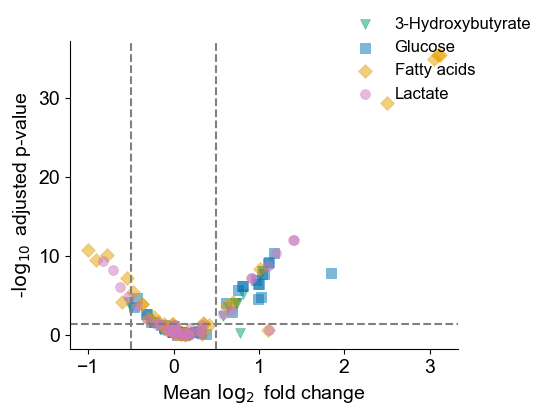

In [28]:
# Make a vulcano plot of the mean fold changes and adjusted p-values
# Increase font size and set the font family to Arial
import matplotlib as mpl
from adjustText import adjust_text

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 4))

# Label parameter 
perturbation_parameter = {
    'lac_L_e': 'Lactate',
    'glc_D_e': 'Glucose',
    'hdca_e': 'Fatty acids',
    'bhb_e': '3-Hydroxybutyrate',
}

# Change the marker type for each parameter
marker_styles = {
    'lac_L_e': 'o',
    'glc_D_e': 's',
    'hdca_e': 'D',
    'bhb_e': 'v',
}

# Choose a hex color for each parameter

colors = {    
     'hdca_e': "#E69F00",  # Vibrant orange
     'glc_D_e': "#0173B2",  # Strong blue  
     'lac_L_e' : "#CC78BC",   # Light magenta
     'bhb_e': "#029E73",   # Teal green
}

# Collect text objects for adjustment
texts = []

for each in mean_fold_changes.index:
    plt.scatter(mean_fold_changes.loc[each], -np.log10(adjusted_p_values.loc[each]), 
                label=perturbation_parameter.get(each, each), alpha=0.5
                , marker=marker_styles.get(each, 'o'), s=50, linewidth=0.5, 
                color=colors.get(each, 'black'), 
                )
# Add invisible repelling points
# These will act as repelling anchors to push labels in desired directions
repel_points = []

# Add invisible points on the left side to repel negative labels leftward
for y_pos in np.arange(0, 25, 100):
    repel_points.append(plt.scatter(-0.5, y_pos, alpha=0, s=1))

# Add invisible points on the right side to repel positive labels rightward  
for y_pos in np.arange(0, 25, 100):
    repel_points.append(plt.scatter(0.5, y_pos, alpha=0, s=10))

plt.axhline(-np.log10(0.05), color='grey', linestyle='--',)
plt.axvline(-0.5, color='grey', linestyle='--')
plt.axvline(0.5, color='grey', linestyle='--')

#plt.xlim(-2,2)

plt.xlabel('Mean $\log_2$ fold change')
plt.ylabel('-$\log_{10}$ adjusted p-value')
sns.despine()
# Legend outside the plot
plt.legend(bbox_to_anchor=(0.7, 1.1), loc='upper left', borderaxespad=0., fontsize=12 ,frameon=False)



# Save the plot as svg
plt.savefig('concentration_fold_changes_volcano_plot_ne_reg.svg', bbox_inches='tight')

In [29]:
# Write the outout to a csv file
mean_fold_changes.to_csv(f'concentration_log_fold_changes_no_reg_{np.round(perturbation)}.csv', index=True)